In [266]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input,Dense,LSTM,Dropout,MultiHeadAttention,LayerNormalization,GlobalAveragePooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import MeanSquaredError,MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

from time import perf_counter
import os

## you could delete this line here (os one)
- i needed it cause im using wsl for tensorflow, but in normal windows, its possible to remove it 

In [ ]:
import os
os.chdir('/tf-acno-projects/Project-Data-Mining')

In [ ]:
def X_y_forecasting_splits(Datafile,time_steps):
    X,y = list(),list()
    for start in range(len(Datafile)):
        end = start+time_steps 
        if end>len(Datafile)-1:
            break
        X.append(Datafile.iloc[start:end].values)
        y.append(Datafile.iloc[end]["CO2 Emission"])
    return np.array(X),np.array(y)

In [ ]:
def months_converter(DataFile):
    unique_months = DataFile['Month'].unique()
    months_dict = {
        month:idx+1 for idx,month in enumerate(unique_months)
    }
    DataFile['Month'] = DataFile['Month'].map(months_dict)

In [ ]:
def lstm_architecture(input_shape,lr,d_model):
    input_layer = Input(shape=input_shape)
    hidden_layer = LSTM(d_model//2, return_sequences=True)(input_layer)
    hidden_layer = LSTM(d_model//4)(hidden_layer)
    hidden_layer = Dense(d_model//8,activation='relu')(hidden_layer)
    output_layer = Dense(1,activation='linear')(hidden_layer)

    lstm_model = Model(input_layer,output_layer)
    lstm_model.compile(optimizer=Adam(learning_rate=lr),loss=MeanSquaredError(),metrics=[MeanAbsoluteError()])
    return lstm_model

In [283]:
def positional_encoding(sequence_length,d_model,n=10000):
    """
    - d_model: the dimension of our input ( output of the embedding space )
    - sequence_length: the length of our sequence for example we have 3 features then its 3
    """
    PosEnc = np.zeros((sequence_length,d_model))
    indices = np.arange(int(d_model/2))
    positions = np.arange((sequence_length))
    
    for position in positions:
        for index in indices:
            denomenator = np.power(n,2*index/d_model)
            PosEnc[position,2*index] = np.sin(position/denomenator)
            PosEnc[position,2*index+1] = np.cos(position/denomenator)

    pos_enc_tensor = tf.constant(PosEnc, dtype=tf.float32)
    pos_enc_tensor = tf.reshape(pos_enc_tensor, (1, sequence_length, d_model))
    return pos_enc_tensor

In [284]:
def transformer_embedding_positioning(sequence_length,d_model,input_layer):
    """
    - We use **the embedding** which is a way to convert raw input into a high-dimensional vector (d_model in this case).
        so our embedding vector shape is **(batch_size,time,features_embedding)**
    - **Positional encoding** is added to this embedding vector so the model knows about the position of each token or feature.
    """
    x_embedded = Dense(d_model)(input_layer)
    pos_enc = positional_encoding(sequence_length,d_model)
    return x_embedded + pos_enc

In [285]:
def transformer_encoder(x,d_model,num_heads,key_dim):
    attention_layer = MultiHeadAttention(num_heads=num_heads,key_dim=key_dim)(x,x)
    add_norm1 = LayerNormalization(epsilon=1e-6)(x+attention_layer)
    
    feed_forward_input = Dense(d_model*2,activation='relu')(add_norm1)
    feed_forward_output = Dense(d_model)(feed_forward_input)
    add_norm2 = LayerNormalization(epsilon=1e-6)(add_norm1+feed_forward_output)
    
    return add_norm2

<div align="center">
  <img src="static/encoder_transformer.png" width="300" height="500"/>
</div>

- The image above taken from the Transformer Encoder Architecture set by <a href='https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf' >'Attention is all you need'</a> Paper
- We didnt used the second part (the decoder) cause we want to predict for each input a single output and not as the decoder does by giving a whole batch of outputs 

In [286]:
def transformer_architecture(input_shape,lr,sequence_length,d_model,num_heads,key_dim):   
    input_layer = Input(shape=input_shape)
    x_positioned_embedded = transformer_embedding_positioning(sequence_length,d_model,input_layer) 
    x1 = transformer_encoder(x_positioned_embedded,d_model,num_heads,key_dim)
    x2 = transformer_encoder(x1,d_model,num_heads,key_dim)
    x_last = GlobalAveragePooling1D()(x2)
    output_layer = Dense(1)(x_last)
    
    transformer = Model(input_layer,output_layer)
    transformer.compile(optimizer=Adam(learning_rate=lr),loss=MeanSquaredError(),metrics=[MeanAbsoluteError()])
    return transformer

In [ ]:
def models_perf_metrics_saving(perf_df_path,metrics_df_path,new_perf_df,new_metrics_df):
    if os.path.exists(os.path.join(os.getcwd(), perf_df_path)):   
        performance_df_old = pd.read_csv(perf_df_path)
        performance_df_old = pd.concat([performance_df_old,new_perf_df],ignore_index=True)
        metrics_df_old = pd.read_csv(metrics_df_path)
        metrics_df_old = pd.concat([metrics_df_old,new_metrics_df],ignore_index=True)
        
        performance_df_old.to_csv(perf_df_path,index=False)
        metrics_df_old.to_csv(metrics_df_path,index=False)
        print(f'Concatenation to the old {perf_df_path}, {metrics_df_path} csv files')
    else:
        new_perf_df.to_csv(perf_df_path)
        new_metrics_df.to_csv(metrics_df_path)
        print(f'Creation of new {perf_df_path}, {metrics_df_path} csv files')

In [ ]:
DataFile = pd.read_csv("Emission.csv")
DataFile.head()

In [ ]:
print(DataFile.isnull().sum())
print(DataFile.duplicated().sum())

Alright, there are no null values and no duplicates but there is something wrong with the "Year-Month" column, it's better to split it into two and convert them to numerical values

In [ ]:
DataFile[['Year', 'Month']] = DataFile['Year-Month'].str.split('-', expand=True)

DataFile.drop(columns=['Year-Month'], inplace=True)

In [ ]:
months_converter(DataFile)

for col in DataFile.columns:
    DataFile[col] = pd.to_numeric(DataFile[col],errors='coerce')
print(DataFile)
print(DataFile.dtypes)

In [ ]:
print(f'Dataset Min : {DataFile["CO2 Emission"].min()}')
print(f'Dataset Max : {DataFile["CO2 Emission"].max()}')
print(f'Dataset Mean : {DataFile["CO2 Emission"].mean()}')
print(f'Dataset STD : {DataFile["CO2 Emission"].std()}')
DataFile.to_csv("New Emission.csv", index=False)

this is a note that we should scale the data later on for our models so we could detect overfitting or underfitting

### Visual Analysis

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(DataFile["Year"], DataFile["CO2 Emission"], marker="o", linestyle="-", color="b")

# Labels and Title
plt.xlabel("Year")
plt.ylabel("CO2 Emission (ppm)")
plt.title("CO2 Emission Over the Years")
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(x=DataFile["Month"], y=DataFile["CO2 Emission"], palette="coolwarm")

# Labels and Title
plt.xlabel("Month")
plt.ylabel("CO2 Emission (ppm)")
plt.title("CO2 Emission by Month")

# Show the plot
plt.show()

In [ ]:
plt.figure(figsize=(12, 5))
sns.barplot(x=DataFile["Year"], y=DataFile["CO2 Emission"], palette="coolwarm")

# Labels and Title
plt.xlabel("Year")
plt.ylabel("CO2 Emission (ppm)")
plt.title("CO2 Emission by Year")

plt.xticks(rotation=45, ha="right")

# Show the plot
plt.show()

It's kind of a complex figure so we will group the years into ranges

In [ ]:
min_year = DataFile["Year"].min()
max_year = DataFile["Year"].max()

print(min_year)
print(max_year)

In [ ]:
bins = [1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015]

labels = ["1971-1975", "1976-1980", "1981-1985", "1986-1990", "1991-1995", "1996-2000", "2001-2005", "2006-2010", "2011-2015"]

DataFile["Year Range"] = pd.cut(DataFile["Year"], bins=bins, labels=labels, right=True)
print(DataFile[["Year", "Year Range"]].head())

In [ ]:
plt.figure(figsize=(12, 5))  # Increase width
sns.barplot(x=DataFile["Year Range"], y=DataFile["CO2 Emission"], palette="coolwarm")

plt.xlabel("Year Range")
plt.ylabel("CO2 Emission (ppm)")
plt.title("CO2 Emission by Year")

plt.xticks(rotation=45, ha="right")  # Rotate labels for better spacing

plt.show()


In [ ]:
DataFile.drop(columns=['Year Range'], inplace=True)

## Training Process !

In [292]:
DataFile = pd.read_csv("New Emission.csv") # reading our cleaned dataset

## LSTM AND TRANSFORMERS


In [293]:
TIME_STEP = 6
INPUT_SHAPE = (TIME_STEP,3) # (time_step, features)
LR = 0.001
EPOCHS = 80
N_SPLITS = 3
D_MODEL = 128
CALLBACK = [
    ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.6,
    patience=10,
    min_delta=0.0001,
    min_lr=1e-6,
    ),]
#EarlyStopping(monitor="val_loss",patience=20,min_delta=0.0001,)

In [294]:
X,y = X_y_forecasting_splits(DataFile,TIME_STEP)
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y.reshape(-1,1)).flatten()

### LSTM

In [ ]:
folds_histories = []
folds_metrics = []
lstm_perf_filename = 'lstm_performance.csv'
lstm_metrics_filename = 'lstm_metrics.csv'

time_series_split_folds = TimeSeriesSplit(n_splits=N_SPLITS)
for fold ,(training_idx, validation_idx) in enumerate(time_series_split_folds.split(X,y)):
    lstm_model = lstm_architecture(INPUT_SHAPE,LR,D_MODEL)

    X_train_cv = tf.convert_to_tensor(X[training_idx], dtype=tf.float32)
    X_val_cv = tf.convert_to_tensor(X[validation_idx], dtype=tf.float32)
    y_train_cv = tf.convert_to_tensor(y_scaled[training_idx], dtype=tf.float32)
    y_val_cv = tf.convert_to_tensor(y_scaled[validation_idx], dtype=tf.float32)
    
    train_start = perf_counter()
    history = lstm_model.fit(X_train_cv,y_train_cv,epochs=EPOCHS,validation_data=(X_val_cv,y_val_cv),callbacks=CALLBACK,verbose=0)
    train_end = perf_counter()
    
    val_loss, val_mae = lstm_model.evaluate(X_val_cv, y_val_cv,verbose=0)
    
    y_val_preds = lstm_model.predict(X_val_cv)
    # Reshape predictions
    y_val_preds_reshaped = y_val_preds.reshape(-1, 1) # from (dim1,1) to (dim1,)

    # Apply inverse transform
    y_val_preds_original = scaler.inverse_transform(y_val_preds_reshaped).flatten() # to get the original co2 values not between 0-1

    # Reshape validation data
    y_val_reshaped = y_val_cv.numpy().reshape(-1, 1) # from (dim1,1) to (dim1,)

    # Apply inverse transform
    y_val_original = scaler.inverse_transform(y_val_reshaped).flatten() # to get the original co2 values not between 0-1
    
    # Calculating the metrics :
    y_mean = np.mean(y_val_original)
    mae_scaled_calculated = np.mean(np.abs(y_val_preds_reshaped - y_val_reshaped))
    mae_calculated = np.mean(np.abs(y_val_preds_original - y_val_original))
    mape_calculated = np.mean(np.abs((y_val_preds_original - y_val_original) / y_val_original)) # mape = 1/n * sum( abs(y_real - y_predicted) )
    
    sce = np.sum((y_val_preds_original - y_mean) ** 2)
    sst = np.sum((y_val_original - y_mean) ** 2)
    r2_calculated = sce / sst # r2 = SCE / SST
    
    fold_history = history.history.copy()
    fold_history['fold'] = fold
    folds_metrics.append({
        'fold':fold,
        'training_time':train_end-train_start,
        'mae_scaled_calculated':mae_scaled_calculated,
        'mae_calculated':mae_calculated,
        'mape_calculated':mape_calculated,
        'r2_calculated':r2_calculated
    })
    folds_histories.append(fold_history)
    
performance_df = pd.concat([pd.DataFrame(h) for h in folds_histories])
metrics_df = pd.DataFrame(folds_metrics)

performance_df.to_csv(lstm_perf_filename)
metrics_df.to_csv(lstm_metrics_filename)
lstm_model.save('lstm_model.keras')
#models_perf_metrics_saving(lstm_perf_filename,lstm_met_filename,performance_df,metrics_df)

### Transformer

In [295]:
SEQ_LEN = TIME_STEP

NUM_HEADS = 4
KEY_DIM = D_MODEL//NUM_HEADS

In [ ]:
folds_histories = []
folds_metrics = []
transformer_perf_filename = 'transformer_performance.csv'
transformer_metrics_filename = 'transformer_metrics.csv'

time_series_split_folds = TimeSeriesSplit(n_splits=N_SPLITS)
performance = []
for fold ,(training_idx, validation_idx) in enumerate(time_series_split_folds.split(X,y)):
    transformer_model = transformer_architecture(INPUT_SHAPE,LR,SEQ_LEN,D_MODEL,NUM_HEADS,KEY_DIM)

    X_train_cv = tf.convert_to_tensor(X[training_idx], dtype=tf.float32)
    X_val_cv = tf.convert_to_tensor(X[validation_idx], dtype=tf.float32)
    y_train_cv = tf.convert_to_tensor(y_scaled[training_idx], dtype=tf.float32)
    y_val_cv = tf.convert_to_tensor(y_scaled[validation_idx], dtype=tf.float32)
    
    train_start = perf_counter()
    history = transformer_model.fit(X_train_cv,y_train_cv,epochs=EPOCHS,validation_data=(X_val_cv,y_val_cv),callbacks=CALLBACK,verbose=0)
    train_end = perf_counter()
    
    val_loss, val_mae = transformer_model.evaluate(X_val_cv, y_val_cv,verbose=0)
    
    y_val_preds = transformer_model.predict(X_val_cv)

    # Reshape predictions
    y_val_preds_reshaped = y_val_preds.reshape(-1, 1) # from (dim1,1) to (dim1,)

    # Apply inverse transform
    y_val_preds_original = scaler.inverse_transform(y_val_preds_reshaped).flatten() # to get the original co2 values not between 0-1

    # Reshape validation data
    y_val_reshaped = y_val_cv.numpy().reshape(-1, 1) # from (dim1,1) to (dim1,)

    # Apply inverse transform
    y_val_original = scaler.inverse_transform(y_val_reshaped).flatten() # to get the original co2 values not between 0-1
    
    # Calculating the metrics :
    y_mean = np.mean(y_val_original)
    mae_scaled_calculated = np.mean(np.abs(y_val_preds_reshaped - y_val_reshaped))
    mae_calculated = np.mean(np.abs(y_val_preds_original - y_val_original))
    mape_calculated = np.mean(np.abs((y_val_preds_original - y_val_original) / y_val_original)) # mape = 1/n * sum( abs(y_real - y_predicted) )
    
    sce = np.sum((y_val_preds_original - y_mean) ** 2)
    sst = np.sum((y_val_original - y_mean) ** 2)
    r2_calculated = sce / sst # r2 = SCE / SST
    
    fold_history = history.history.copy()
    fold_history['fold'] = fold
    folds_metrics.append({
        'fold':fold,
        'training_time':train_end-train_start,
        'mae_scaled_calculated':mae_scaled_calculated,
        'mae_calculated':mae_calculated,
        'mape_calculated':mape_calculated,
        'r2_calculated':r2_calculated
    })
    folds_histories.append(fold_history)
    
performance_df = pd.concat([pd.DataFrame(h) for h in folds_histories])
metrics_df = pd.DataFrame(folds_metrics)

performance_df.to_csv(transformer_perf_filename)
metrics_df.to_csv(transformer_metrics_filename)
transformer_model.save('transformer_model.keras')

4/4 [==============================] - 0s 6ms/step


In [ ]:
perf = pd.read_csv('transformer_performance.csv')
perf.drop(columns=['Unnamed: 0'],inplace=True)
print(perf[-5:])

         loss  mean_absolute_error  val_loss  val_mean_absolute_error  \
235  0.035740             0.157760  0.129262                 0.338287   
236  0.034813             0.157727  0.136738                 0.348980   
237  0.034758             0.157614  0.143093                 0.357827   
238  0.034778             0.157237  0.134848                 0.346318   
239  0.034567             0.152259  0.138819                 0.351911   

           lr  fold  
235  0.000078     2  
236  0.000078     2  
237  0.000078     2  
238  0.000047     2  
239  0.000047     2  


In [ ]:
def plot_training_history(train_loss,val_loss):
    plt.figure(figsize=(12, 6))
    
    plt.plot(train_loss, 'b-o', label='Training Loss')
    plt.plot(val_loss, 'r-o', label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

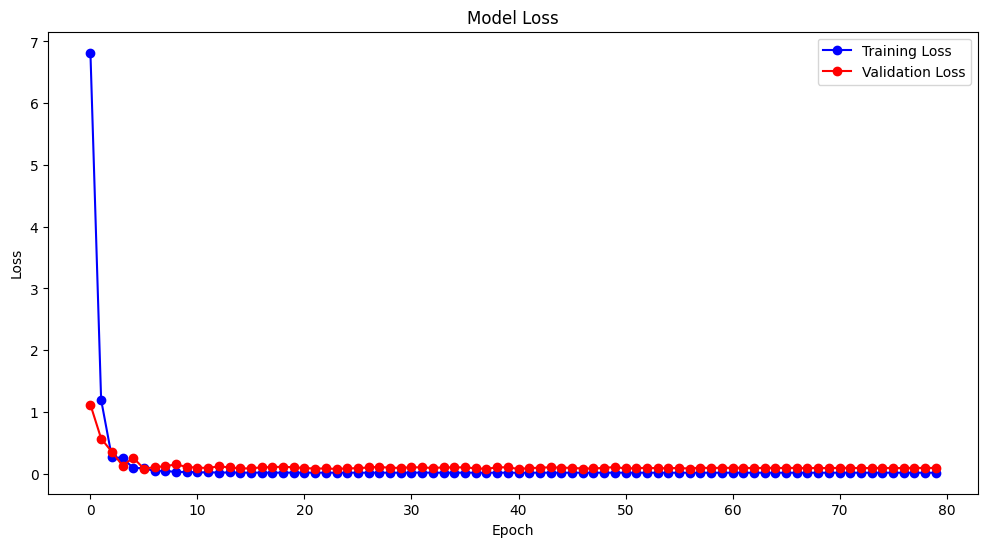

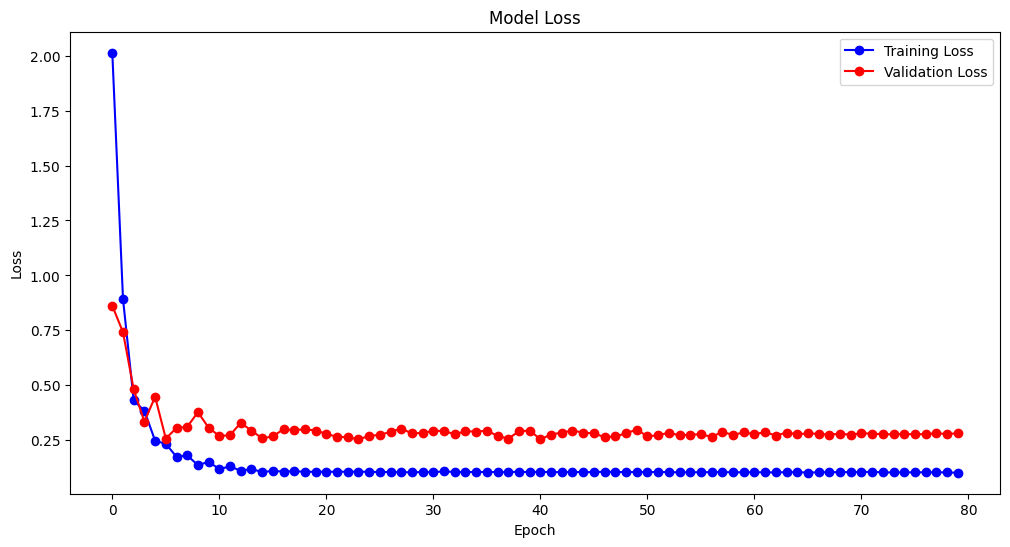

In [ ]:
fold0 = perf[perf['fold'] == 0]
fold1 = perf[perf['fold'] == 1]
fold2 = perf[perf['fold'] == 2]

fold0_reset = fold0.reset_index(drop=True)
fold1_reset = fold1.reset_index(drop=True)
fold2_reset = fold2.reset_index(drop=True)

# Make sure all folds have the same columns before adding
numeric_columns = ['loss','mean_absolute_error','val_loss','val_mean_absolute_error']

avg = (fold0_reset[numeric_columns] + fold1_reset[numeric_columns] + fold2_reset[numeric_columns]) / 3
plot_training_history(avg['loss'],avg['val_loss'])
plot_training_history(avg['mean_absolute_error'],avg['val_mean_absolute_error'])

In [ ]:
transf_model = tf.keras.saving.load_model('transformer_model.keras')
DataFile = pd.read_csv("Emission.csv")

split_ratio = 0.8
train_size = int(len(DataFile) * split_ratio)
_, test = X[:train_size], X[train_size:]
preds = transf_model.predict(test)
y_val_preds_1D = preds.reshape(-1, 1)
y_val_preds_original = scaler.inverse_transform(y_val_preds_1D).flatten()


train, test = DataFile[:train_size], DataFile[train_size:]
test_trimmed = test.iloc[-len(y_val_preds_original):]

3/3 [==============================] - 0s 9ms/step


In [ ]:
print("Raw model predictions (before inverse transform):")
print(y_val_preds[:5])  # shape should be (n_samples, 3)


Raw model predictions (before inverse transform):
[[0.4120651 ]
 [0.41284052]
 [0.41349098]
 [0.4132995 ]
 [0.41332036]]


In [ ]:
print("After inverse transform:")
print(y_val_preds_original[:5])


After inverse transform:
[129.98117 130.00438 129.96655 129.93965 129.8743 ]


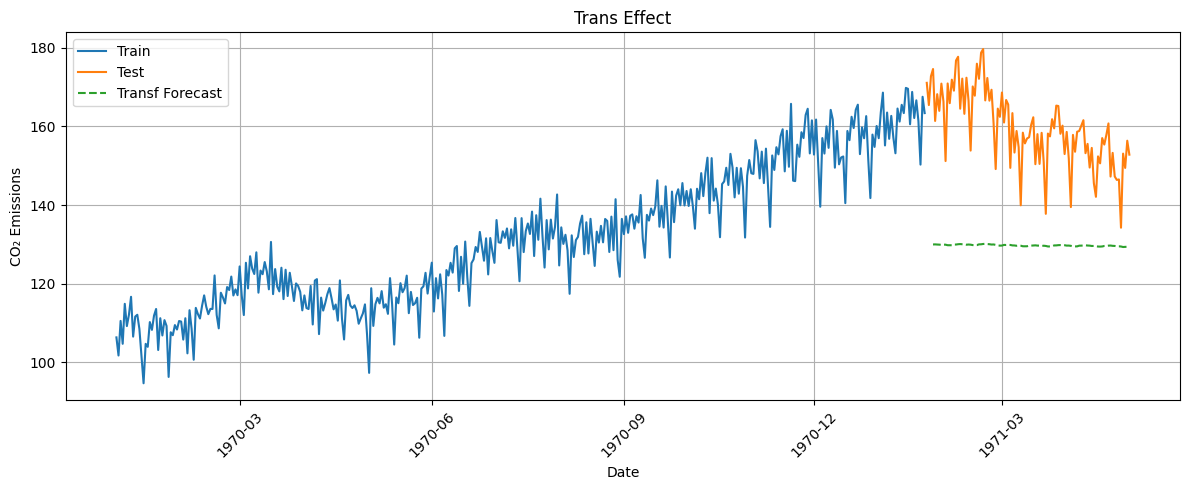

In [ ]:
import matplotlib.dates as mdates
plt.figure(figsize=(12, 5))
plt.plot(train['Year-Month'], train['CO2 Emission'], label='Train')
plt.plot(test['Year-Month'], test['CO2 Emission'], label='Test')
plt.plot(test_trimmed['Year-Month'], y_val_preds_original, label='Transf Forecast', linestyle='--')
plt.title(f'Trans Effect')
plt.xlabel('Date')
plt.ylabel('CO₂ Emissions')
plt.legend()
plt.grid(True)

# Date formatting
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

#### Adding the year-month as our indecies !!

In [ ]:
df = pd.read_csv('New Emission.csv')
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str).str.zfill(2))
df.set_index('Date', inplace=True)
df = df.asfreq('MS')  # Monthly Start frequency